# Universal Kriging for reconstructing via sensor measuring the NLTI

In [530]:
#Cargando librerías 

import importlib
import positioning_sensors as ps
importlib.reload(ps)

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from pykrige import OrdinaryKriging

import pykrige.kriging_tools as kt

plt.style.use("ggplot")

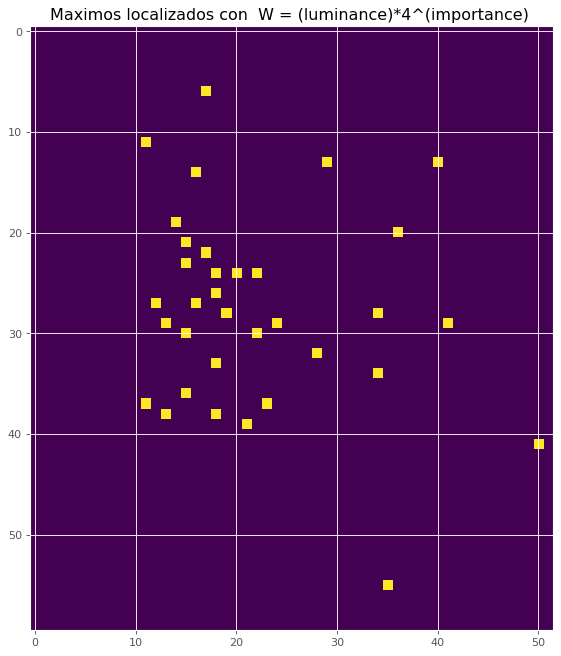

In [531]:
#cargamos imagenes en luminance e importance
ilumina = 'example/inputs/qro_light_th'
niveles = 'example/inputs/prioridades'
sigma_y = 0.5
sigma_x = 0.5
sigma = [sigma_y,sigma_x]

luminance = ps.readIMG(ilumina)
importance = ps.readIMG(niveles,invert=True)

nonsat = ps.desaturate(luminance,th=62)
nonsat = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')

W1 = ps.f5(nonsat,importance)
seeds = ps.getMax(W1)

seeds_nonsat = ps.getMax(nonsat)
coords_nonsat = ps.get_coords(seeds_nonsat)

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(seeds*np.max(W1)/2+W1)
plt.imshow(seeds)
plt.title("Maximos localizados con  W = (luminance)*4^(importance) ")
plt.show()

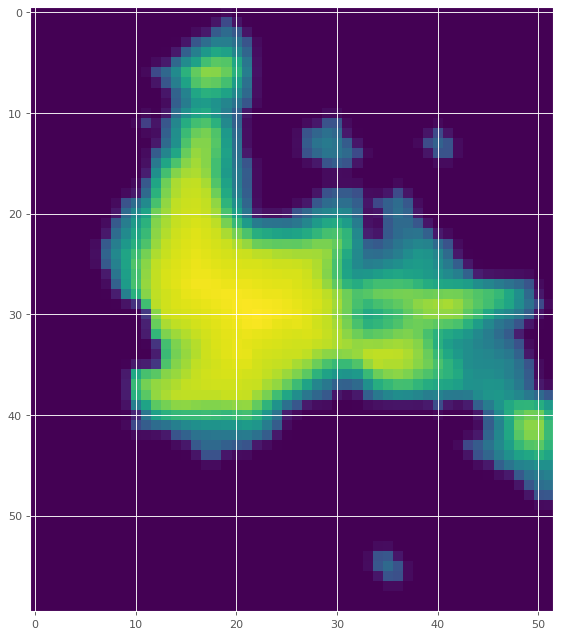

In [532]:
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(nonsat)

In [533]:
def formatData(coords,img):
    z  = np.zeros(len(coords))
    Y = np.zeros(len(coords))
    X = np.zeros(len(coords))
    for i,c in enumerate(coords):
        z[i] = int(img[c[0]][c[1]])
        Y[i],X[i] = int(c[0]),int(c[1])
    return Y,X,z
        
    
y,x,z = formatData(rp, nonsat)


In [534]:
rp = [[np.random.randint(nonsat.shape[0]-1),np.random.randint(nonsat.shape[1]-1)] for i in range(400)]

y,x,z = formatData(rp, nonsat)



In [535]:
uk = OrdinaryKriging(y, x, z, variogram_model="spherical")

In [536]:
gridy = np.arange(0.0, nonsat.shape[0], 1)
gridx = np.arange(0.0, nonsat.shape[1], 1)

In [537]:
z, ss = uk.execute("grid", gridy , gridx)
ss_std = np.squeeze(ss)

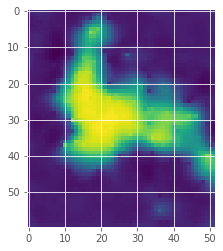

In [538]:
kt.write_asc_grid(gridy, gridx, z, filename="output.asc")
z_r = np.fliplr(np.rot90((np.flip(z))))
#z_r = z

ss_std = np.fliplr(np.rot90((np.flip(ss_std))))
plt.imshow(z_r)
plt.show()

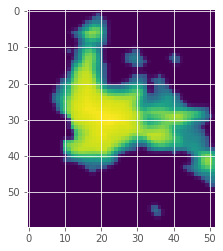

In [539]:
plt.imshow(nonsat)

In [540]:
#dif complement
mask = nonsat==0



dif_c  = nonsat*(mask)-z_r*(mask)
dif  = nonsat*(mask==False)-z_r*(mask==False)

penalty = np.sum((dif_c.flatten()*65)**2)
valid_area = np.sum((dif.flatten())**2)

#(penalty+valid_area)/

#plt.imshow( )

np.mean(dif**2)

#print(np.sum(dif_c.flatten()*65)**2)

#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)
#plt.show()

17.350131810243337

Text(0.5, 1.0, '57766.662118329914')

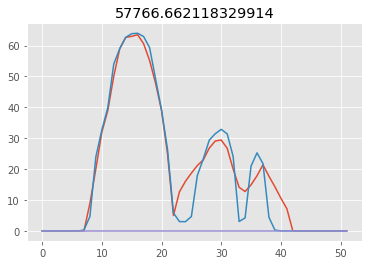

In [541]:
ix= 20
plt.plot(z_r[:][ix]*(nonsat[:][ix]>0))
plt.plot((nonsat[:][ix]))
plt.plot(randomLoc[:][ix]*30)
plt.title(np.sum((nonsat-z_r)**2))


In [542]:
plt.imshow(nonsat-z*(nonsat>0))
plt.title(np.mean((nonsat-z*(nonsat>0))**2))
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()


ValueError: operands could not be broadcast together with shapes (52,60) (60,52) 

In [ ]:
np.linalg

In [735]:
def formatData(coords,img):

    z  = np.zeros(len(coords))
    Y = np.zeros(len(coords))
    X = np.zeros(len(coords))
    for i,c in enumerate(coords):
        z[i] = int(img[c[0]][c[1]])
        Y[i],X[i] = int(c[0]),int(c[1])
    return Y,X,z

def penalty(coords, forbiden_area,big_number=1000000):


    p = 0
    for i in np.arange(len(coords)):

        if forbiden_area[coords[i][0]][coords[i][1]]:
            p += big_number #*np.linalg.norm(coords[i][0]-30,coords[i][1]-30)
            
    return p

def aptitude(X,img=nonsat):
  
    y = np.floor(X[:int(len(X)/2)]).astype(int)
    x = np.floor(X[int(len(X)/2):]).astype(int)
    

    
    gridy = np.arange(0.0, nonsat.shape[0], 1)
    gridx = np.arange(0.0, nonsat.shape[1], 1)
    
    mask = img==0
    
    coords = np.append([y],[x],axis=0).T

    
    x,y,z = formatData(coords,img)
    
#    print("z:",np.sum(z!=0))
    
    if np.sum(z!=0)>5 :
#        print("inside")

        uk = OrdinaryKriging(y, x, z, variogram_model="hole-effect")
        try:
            z, ss = uk.execute("grid", gridy , gridx)
            z_r = np.fliplr(np.rot90((np.flip(z))))

            dif  = img*(mask==False)-z_r*(mask==False)

            valid_area = np.sum((dif.flatten())**2)
        
#        print(valid_area)
            apt = np.mean(valid_area)+penalty(coords,mask)
        except:
            print("Singular matrix")
            apt = 100000000000000000000000*len(z)
    else:
#        print("outside")
        apt = 100000000000000000000000*np.sum((z==0)*1)
    

    return apt

global mz
mz = np.zeros(nonsat.shape)

def cb(X, convergence, img=nonsat):
    global mz
    y = np.floor(X[:int(len(X)/2)]).astype(int)
    x = np.floor(X[int(len(X)/2):]).astype(int)
    
    for i in range(len(y)):
        mz[y[i]][x[i]]=1
        
    plt.imshow(mz*40+img)
    plt.show()
    mz=np.zeros(nonsat.shape)
    
    
def plotResult(X,nonsat=nonsat):
    plt.figure(figsize=(10, 10), dpi=80)
    X = np.floor(X).astype(int)
    x = X[:int(len(X)/2)]
    y =  X[int(len(X)/2):]
    zr = np.zeros(nonsat.shape)
    for c in range(int(len(X)/2)):
        zr[x[c]][y[c]] = 1

    plt.imshow(zr*50+nonsat)
    plt.show()
    
def check(x,y,z,img):
    
    for ix in range(len(z)):
        if z[ix]==0:
            x[ix]=30
            y[ix]=30
            z = nonsat[30][30]
    return x,y,z
    
    

In [736]:
aptitude(X)
#plotResult(X)
n = 30
bnd = [(0,nonsat.shape[0]-1),]

b = [(0,nonsat.shape[ix]) for ix in range(2) for i in range(int(n))]



In [ ]:
from scipy import optimize

r = optimize.differential_evolution(aptitude,b,strategy="best1bin",polish=False,disp = True,workers=2,popsize=50,maxiter=30,callback=cb)

Singular matrix
Singular matrix


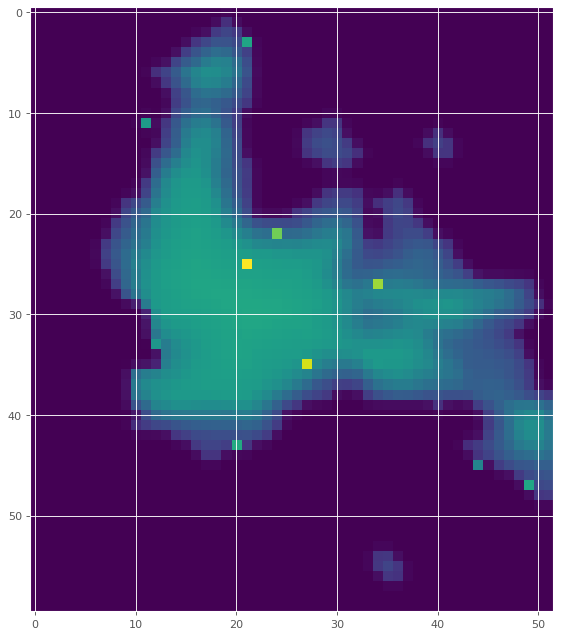

In [630]:
plotResult(r.x)

In [589]:


aptitude(r.x)

    

0

In [493]:
y = (np.floor(r.x[:int(len(r.x)/2)])).astype(int)
x = (np.floor(r.x[int(len(r.x)/2):])).astype(int)
img = nonsat

gridy = np.arange(0.0, img.shape[0], 1)
gridx = np.arange(0.0, img.shape[1], 1)

coords = np.append([y],[x],axis=0).T

x,y,z = formatData(coords,img)

uk = OrdinaryKriging(y, x, z, variogram_model="spherical")
z, ss = uk.execute("grid", gridy , gridx)
z_r = np.fliplr(np.rot90((np.flip(z))))

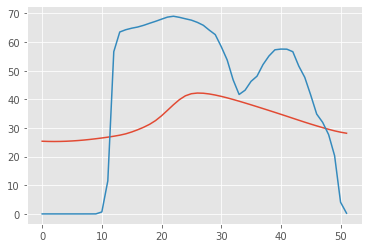

In [496]:
#plt.imshow(z_r)

plt.plot(z_r[30][:])
plt.plot(nonsat[30][:])

In [ ]:
r 
    

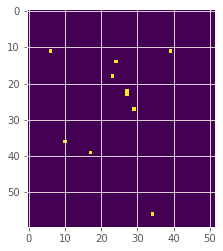

In [121]:
zr = np.zeros(nonsat.shape)
for c in coords:
    zr[c[0]][c[1]] = 1
    
X1 = np.append(X1,r[0])
X2 = np.append(X2,r[1])

Referencias

https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/07_regression_kriging2d.html
https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html?highlight=variogram#variogram-models
https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/07_regression_kriging2d.html
https://link.springer.com/chapter/10.1007%2F978-94-011-5014-9_23